# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-20 09:00:00+09:00,53348.589844,53408.351562,53167.898438,53170.699219,0,0.0,0.0
2026-01-20 09:15:00+09:00,53174.578125,53178.378906,52876.238281,52927.988281,0,0.0,0.0
2026-01-20 09:30:00+09:00,52934.839844,53158.480469,52934.839844,53145.460938,0,0.0,0.0
2026-01-20 09:45:00+09:00,53147.468750,53206.210938,53058.609375,53066.949219,0,0.0,0.0
2026-01-20 10:00:00+09:00,53068.121094,53211.898438,53068.121094,53176.511719,0,0.0,0.0
2026-01-20 10:15:00+09:00,53178.359375,53216.050781,53129.578125,53209.738281,0,0.0,0.0
2026-01-20 10:30:00+09:00,53198.601562,53198.601562,53090.039062,53099.011719,0,0.0,0.0
2026-01-20 10:45:00+09:00,53099.621094,53152.378906,53048.339844,53050.398438,0,0.0,0.0
2026-01-20 11:00:00+09:00,53050.328125,53148.019531,53015.500000,53017.531250,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-01-20 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-01-20 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-01-13 00:00:00+09:00    53549.160156
2026-01-14 00:00:00+09:00    54341.230469
2026-01-15 00:00:00+09:00    54110.500000
2026-01-16 00:00:00+09:00    53936.171875
2026-01-19 00:00:00+09:00    53583.570312
2026-01-20 00:00:00+09:00    53079.679688
Name: Close, dtype: float64


Date
2026-01-19 00:00:00+09:00    53583.570312
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-234.98


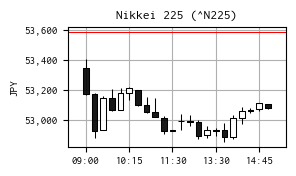

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-01-19 09:00:00+09:00,157.548004,157.875000,157.505997,157.830994,0,0.0,0.0
2026-01-19 09:15:00+09:00,157.828003,157.878998,157.570999,157.666000,0,0.0,0.0
2026-01-19 09:30:00+09:00,157.664993,157.684006,157.511993,157.535995,0,0.0,0.0
2026-01-19 09:45:00+09:00,157.531006,157.604996,157.436005,157.475006,0,0.0,0.0
2026-01-19 10:00:00+09:00,157.473007,157.621994,157.438995,157.507996,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-20 14:15:00+09:00,157.957993,158.037003,157.947006,158.024002,0,0.0,0.0
2026-01-20 14:30:00+09:00,158.029999,158.097000,158.020996,158.082993,0,0.0,0.0
2026-01-20 14:45:00+09:00,158.089996,158.123993,158.042999,158.102005,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-01-20 09:00:00+09:00,337.081797,337.459400,335.940103,335.957799
2026-01-20 09:15:00+09:00,336.233021,336.257054,334.346561,334.673786
2026-01-20 09:30:00+09:00,334.526711,335.940029,334.526711,335.857750
2026-01-20 09:45:00+09:00,336.512684,336.884620,335.950055,336.002860
2026-01-20 10:00:00+09:00,336.025181,336.935573,336.025181,336.711506
2026-01-20 10:15:00+09:00,336.282433,336.520781,335.973957,336.480863
2026-01-20 10:30:00+09:00,336.331739,336.331739,335.645386,335.702113
2026-01-20 10:45:00+09:00,336.184198,336.518218,335.859527,335.872560
2026-01-20 11:00:00+09:00,335.638364,336.256437,335.418014,335.430865


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-01-19 15:15:00+09:00


np.float64(157.88600158691406)

前日終値（ドル換算） 339.3813876716802


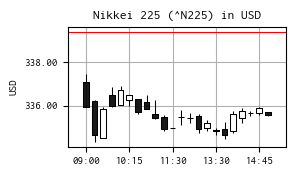

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()